# Helping fight Covid-19 with State Of The Art NLP methods
We developed a preliminary method for addressing one of the Kaggle Covid 19 challenges. Specifically we looked at the geographical influences sample task.

In this task 4 questions were posed, and we managed to get some relevant answers from the papers. for example for the question: “What works have been done on infection spreading?” the engine finds answers such as: “In this outbreak, genotyping helped characterize the transmission of TB among homeless shelter residents and suggested that multiple chains of transmission occurred simultaneously” and “In this chapter, some basic ideas of modelling the spread of infectious diseases, the main concepts of epidemic dynamics, and some developing tendencies in the study of epidemic dynamics are introduced, and some results with respect to the spread of SARS in China are given”.

For additional insight, we examined clustering the documents using our method’s document representation. The clusters appear to be meaningful e.g. one of the clusters focuses on 'livestock' and another on the biological mechanism of covid19...

The notebook seperated into 4 parts:
1.	NLP Process
2.	Evaluation
3.	Insights
4.	Conclusions



Authors: 
* Shaked Greenfeld (Apps Dev Intermed Prgmr Anlyst at CITI innovation labs, TLV)
* Or Levitas(Apps Dev Programmer Analyst at CITI innovation labs, TLV)
* Dvir Levy(Apps Dev Sr. Programmer Anlyst at CITI innovation labs, TLV)
* Gila Halperin(Apps Dev Sr. Programmer Anlyst at CITI innovation labs, TLV)
* Karni Gilon(Apps Development Sr Manager at CITI innovation labs, TLV)

# 1. NLP Method


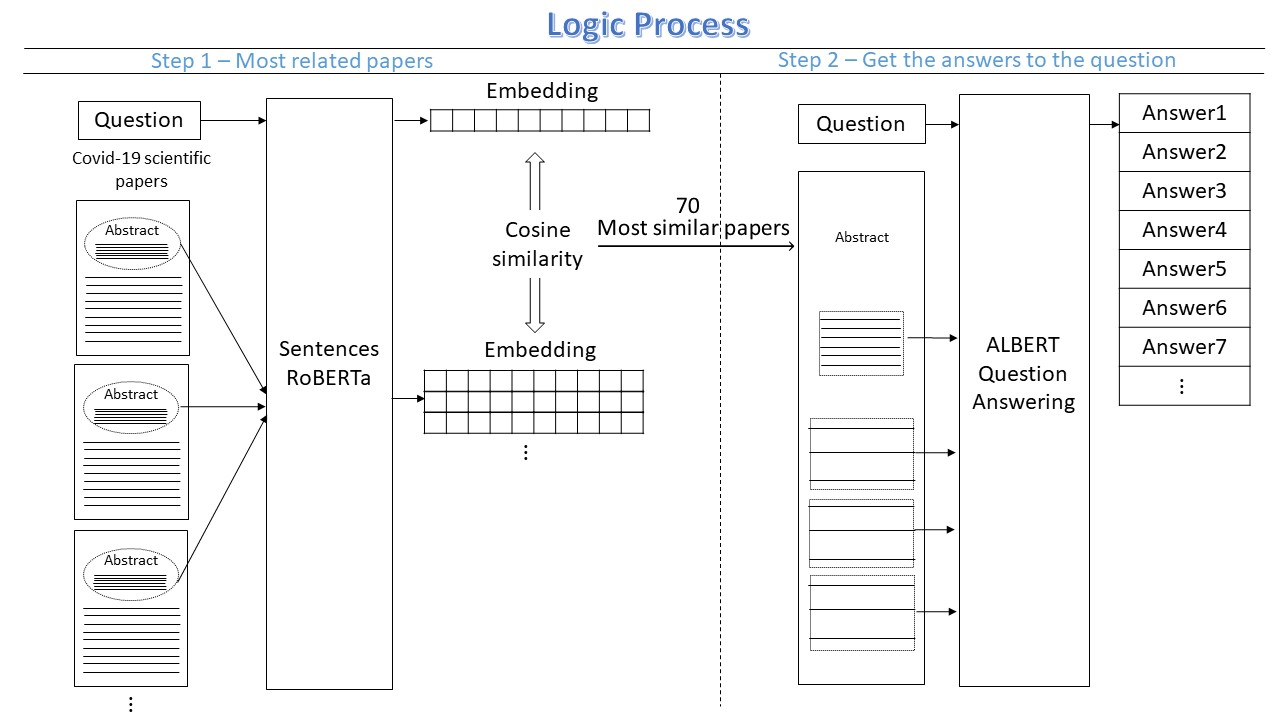

The method includes two parts, as follows
1.	Retrieve the most relevant papers - retrieve the most related papers to the questions. We first calculate a RoBERTa representation for the question. We then calculate the cosine similarity between the question RoBERT representation and the abstracts representations, We retrieve the 70 most similar papers to be used in the next stage.
2.	We split the papers into paragraphs(batch of 7 lines). We run "ALBERT Question Answering" on the question and each of the paragraphs, This process finds the best question-fitting span for each paragraph, along with a confidence score. Spans pertaining to paragraphs with no good answer are expected to have a low confidence score. We sort the span responses according to their confidence score in descending orders. Finally the answers we provide are the paragraphs corresponding to those spans...

Pre-processing: We pre-preprocess the papers, calculating RoBERTa representation for their respective abstracts.
Other methods: prior to choosing RoBERTa and ALBERT we tested several other approached (not reported here) which yielded worse results.

In [ ]:
# Install sentence-transformers
!pip install sentence-transformers

In [ ]:
import os
import re 
import gc
import glob
import json
import scipy
import torch
import pickle
import string
import numpy as np
import pandas as pd
from time import time  
from tqdm import tqdm
from PIL import Image
from sklearn import cluster
from typing import List, Dict
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from transformers import pipeline
from sklearn.decomposition import PCA
from transformers import AutoTokenizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, ImageColorGenerator
from sentence_transformers import SentenceTransformer
from transformers import AutoModelForQuestionAnswering


# Constanst defenition
PCA_NUM_COMPONENT             = 20
NUMPY_SEED                    = 42
MAX_WORDS                     = 3000 
SAMPLES_TNSE                  = 10000
CORONVAVIRUS_PATTERN          = 'CORONA'
NUM_CLUSTERS                  = [5,10,15]
CORRECT_CLASS                 = 'correct'
INCORRECT_CLASS               = 'incorrect'
COVID19_PICTURE_PATH          = r'/kaggle/input/images/covid19_pic.png'
CLUSTRING_INFO_PATH           = r'/kaggle/working/clusters_info.pkl'
CLUSTERS_DICT_PATH            = r'/kaggle/working/clusters_dict.pkl'
ROOT_PATH                     = r'/kaggle/input/CORD-19-research-challenge'
MATRIX_ABSTRACT_PATH          = r'/kaggle/working/abstract_emb_arr.npy'
ARTICLES_ABS_PATH             = r'/kaggle/working/articles_abstract.pkl'
IMAGE_CLUD_PATH_REGULAR       = r'/kaggle/working/image_cloud.png'
ANNOT_ANSWER1_PATH            = r'/kaggle/input/manually-annotated-q/Q1_annotated.pkl'
ANNOT_ANSWER2_PATH            = r'/kaggle/input/manually-annotated-q/Q2_annotated.pkl'
ANNOT_ANSWER3_PATH            = r'/kaggle/input/manually-annotated-q/Q3_annotated.pkl'
ANNOT_ANSWER4_PATH            = r'/kaggle/input/manually-annotated-q/Q4_annotated.pkl'
METADATA_PATH                 = r'/kaggle/input/CORD-19-research-challenge/metadata.csv'
ARTICLES_ABS_PLUS_ENCODE_PATH = r'/kaggle/working/articles_abstract_plus_encode.pkl'
IMAGE_CLUD_PATH_CORONA_MASK   = r'/kaggle/working/wc_cluster_{}_class_{}.png'
ANSWER2_PATH                  = r'/kaggle/working/2_What_works_have_been_done_on_infection_spreading.csv'
ANSWER1_PATH                  = r'/kaggle/working/1_Are_theregeographic_variations_in_the_rate_of_COVID-19_spread.csv'
ANSWER3_PATH                  = r'/kaggle/working/3_Are_there_geographic_variations_in_the_mortality_rate_of_COVID.CSV'
ANSWER4_PATH                  = r'/kaggle/working/4_Is_there_any_evidence_to_suggest_geographic_based_virus_mutations.csv'



# Remove uninformative words
REMOVE_TERMS                  = ['covid19','corona','coronavirus','covid','covid','results','result','result','one','two','use','used','using','well', \
                                 'including','found','although','method','conclusion','case','observed','model','showed','due','three', 'cases','system',\
                                 'among','known','case','type','time','total','different','activity','based','level','effect','thu','within','may','compared',\
                                 'show','many','few','et al','following','similar','data','methods','detected','approach','change','multiple','several',\
                                 'detected','first','specific','increase','response','include','need','report','suggest','identified','finding','addition']



%matplotlib inline

In [ ]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            if 'abstract' in content:
                for entry in content['abstract']:
                    self.abstract.append(entry['text'])
            else:
                self.abstract.append('Not provided.')
            # Body text
            if 'body_text' in content:
                for entry in content['body_text']:
                    self.body_text.append(entry['text'])
            else:
                self.body_text.append('Not provided.')
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)


    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
    
def get_date_dt(all_json, meta_df):    
    dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [],
             'abstract_summary': []}
    for idx, entry in tqdm(enumerate(all_json), desc="Parsing the articles Json's content", total=len(all_json)):
        try:
            content = FileReader(entry)
        except:
            continue

        # get metadata information
        meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
        # no metadata, skip this paper
        if len(meta_data) == 0:
            continue

        dict_['paper_id'].append(content.paper_id)
        dict_['abstract'].append(content.abstract)
        dict_['body_text'].append(content.body_text)
        
        # get metadata information
        meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]

        try:
            # if more than one author
            authors = meta_data['authors'].values[0].split(';')
            if len(authors) > 2:
                # more than 2 authors, may be problem when plotting, so take first 2 append with ...
                dict_['authors'].append(". ".join(authors[:2]) + "...")
            else:
                # authors will fit in plot
                dict_['authors'].append(". ".join(authors))
        except Exception as e:
            # if only one author - or Null valie
            dict_['authors'].append(meta_data['authors'].values[0])

        # add the title information, add breaks when needed
        dict_['title'].append(meta_data['title'].values[0])

        # add the journal information
        dict_['journal'].append(meta_data['journal'].values[0])
        

    return pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal'])

In [ ]:
# The following code needed to be run only once(!)
# Get all the data of json articles
meta_df = pd.read_csv(METADATA_PATH, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str,
    'doi': str
})

all_json = glob.glob(f'{ROOT_PATH}/**/*.json', recursive=True)
data_dt = get_date_dt(all_json, meta_df)


# Encode the articles accorfing to their abstract
encoder = SentenceTransformer("roberta-large-nli-stsb-mean-tokens")
articles_abstract = data_dt
encoded_articles_abstract = encoder.encode(articles_abstract['abstract'].tolist())
articles_abstract['encoded_articles_abstract'] = encoded_articles_abstract   
with open(ARTICLES_ABS_PLUS_ENCODE_PATH, 'wb') as handle:
    pickle.dump(articles_abstract, handle)

In [ ]:
def query_questions(query, encoded_query, articles_abstract):    
    articles_abstract['distances'] = scipy.spatial.distance.cdist([encoded_query], articles_abstract['encoded_articles_abstract'].tolist(), "cosine")[0]
    articles_abstract = articles_abstract.sort_values('distances').reset_index()[:70]
    
    articles_abstract['sentence_list'] = [body.split(". ") for body in articles_abstract['body_text'].to_list()] 
    paragraphs = []
    for index, ra in articles_abstract.iterrows():
        para_to_add = [". ".join(ra['sentence_list'][n:n+7]) for n in range(0, len(ra['sentence_list']), 7)]        
        para_to_add.append(ra['abstract'])
        paragraphs.append(para_to_add)
    articles_abstract['paragraphs'] = paragraphs
    answers = answer_question(query, articles_abstract)
    return answers

def get_QA_bert_model():
    torch_device = 0 if torch.cuda.is_available() else -1
    tokenizer = AutoTokenizer.from_pretrained("ahotrod/albert_xxlargev1_squad2_512")
    model = AutoModelForQuestionAnswering.from_pretrained("ahotrod/albert_xxlargev1_squad2_512")
    return pipeline('question-answering', model=model, tokenizer=tokenizer,device=torch_device)

def answer_question(question: str, context_list):
    # anser question given question and context
    answers =[]
    all_para = [item for sublist in context_list['paragraphs'].to_list() for item in sublist] 
    print(f"paragraph to scan: {len(all_para)}")
    for _, article in context_list.iterrows():
        for context in article['paragraphs']:
            if len(context) < 10:
                continue
            with torch.no_grad():
                answer = nlp_qa(question=question, context=context)
            answer['paragraph'] = context
            answer['paper_id'] = article['paper_id']
            answers.append(answer)            
    df = pd.DataFrame(answers)
    df = df.sort_values(by='score', ascending=False)
    return df

In [ ]:
nlp_qa = get_QA_bert_model()
questions = ["Are there geographic variations in the rate of COVID-19 spread?",\
                                "What works have been done on infection spreading?",\
                                "Are there geographic variations in the mortality rate of COVID-19?",\
                                "Is there any evidence to suggest geographic based virus mutations?"]
encoded_query = encoder.encode(questions)

del encoder
gc.collect()

In [ ]:
answer1 = query_questions(questions[0],encoded_query[0], articles_abstract)
answer1.to_csv(ANSWER1_PATH)
answer1.head()

In [ ]:
answer2 = query_questions(questions[1], encoded_query[1], articles_abstract)
answer2.to_csv(ANSWER2_PATH)
answer2.head()

In [ ]:
answer3 =  query_questions(questions[2], encoded_query[2], articles_abstract)
answer3.to_csv(ANSWER3_PATH)
answer3.head()

In [ ]:
answer4 =  query_questions(questions[3], encoded_query[3], articles_abstract)
answer4.to_csv(ANSWER4_PATH)
answer4.head()

In [ ]:
del articles_abstract
gc.collect()

# 2. Evaluation & Results
A small team (not involved in developing the method) evaluated the answers provided by our engine for the four questions posed in the sample task.  We manually evaluated the highest confidence 50 answers for each question and measured against that small dataset in means of information retrieval and precision. Note: for regular search engines, fewer answers may be needed; however, we are trying to extract as many insights as possible for the question, beyond the first few. In addition, while our logic tried to find the most fitting answer, the original task definition is to compose the best answers. Such composition is best formed out of several answers.

Results
Out of the 3 highest confidence answers, at least one was correct in  42% of the cases. The Mean Average Precision over the ~50 answers is 22%. Note: for the latter calculation we did not consider the score confidence (rather – we considered all 50 answers as if the engine regarded them as correct).

Examples of insightful answers:

**QUESTION1**:

Are there geographic variations in the rate of COVID-19 spread?

**ANSWERS**:
1. 	COVID-19 growth rate exponents are greater in larger cities
1. 	Decision-makers get serious benefits from using better and more flexible models as they can avoid of nuanced lock-downs, better plan the exit strategy based on local population data, different stages of the epidemic in different areas, making specific recommendations to specific groups of people; all this resulting in a lesser impact on economy, improved forecasts of regional demand upon NHS allowing for intelligent resource allocation.
1. 	Of course, the model can be applied to any other country or region. In the paper the results are presented in detail for Bulgaria, Italy and globally.


**QUESTION2**:

What works have been done on infection spreading?

**ANSWERS**:
1. 	In this outbreak, genotyping helped characterize the transmission of TB among homeless shelter residents and suggested that multiple chains of transmission occurred simultaneously')
1. For example, advances in virology have been instrumental in improving the usefulness of surveillance data to understand the epidemiology of viral hepatitis.
1. In this chapter, some basic ideas of modelling the spread of infectious diseases, the main concepts of epidemic dynamics, and some developing tendencies in the study of epidemic dynamics are introduced, and some results with respect to the spread of SARS in China are given.

**QUESTION3**:

Are there geographic variations in the mortality rate of COVID-19?

**ANSWERS**:
1. For the recorded number of deaths from COVID-19, Italy has the highest number of deaths from the disease followed by Spain, USA, UK, Sweden, Ghana and Nigeria (least) over the 45 days period (Fig. 2)
1. When faced with the same COVID-19 during the fight against the epidemic, medical health workers in rural areas might worry about being infected due to a different working place involving different medical skills and medical conditions. In contrast, the medical conditions in urban areas were often much better'
1. Highly sophisticated epidemiological models involving, for instance, spatial resolution and networks of social connections, can be of great use in making detailed predictions, provided that the relevant parameters are adequately known. This is not yet the case for COVID-19, given that estimates of the basic reproduction number itself differ substantially

**QUESTION4**:

Is there any evidence to suggest geographic based virus mutations?

**ANSWERS**:

1. Additionally, model results showed two geographical clusters with high predicted host diversity: one extending across central sub-Saharan Africa to the southeastern coast of Africa, and the second encompassing the Neotropic region and Central Americas
1. Several important limitations must be considered in our extrapolations, including (i) the assumption that a mean of 58 viruses per species is a reasonable estimate and that host populations are panmictic with respect to viral transmission (such that expanded geographic sampling would not influence viral detec-tions)
1. Mean probabilities for other Orders were not significantly different from each other (Mann-Whitney-Wilcoxon Bonferroni-adjusted P > 0.05, Supplementary Figure 12 ). The geographical distribution of these species showed high species diversity clusters across Europe and Russia


In [ ]:
# Load the annotations
def load_annotations(path):
    with open(path, 'rb') as handle:
        annotations = pickle.load(handle)
    
    return annotations

# Only the correct an incorrect classification account in the measurement
def get_only_correct_incorrect_data(annotations):
    clean_annotations   = []
    
    for annot in annotations:
        if annot[-1] in [CORRECT_CLASS,INCORRECT_CLASS]:
            clean_annotations.append(annot[-1])
            
    return clean_annotations

# Calculate the mean-average-precision
# Wilipedia: https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Mean_average_precision
def calc_average_precision(annot_list):
    
    average_precision = 0
    correct_annot = 0
    total_relevat = len(annot_list)
    
    for ii, annot in enumerate(annot_list,1):
        if annot == CORRECT_CLASS:
            correct_annot += 1.0
            average_precision += correct_annot/ii
    
    return average_precision/total_relevat


def calc_precision_among_1(q_list):
    correct_annot = 0
    q_checked_list = q_list[:1]

    for q_i in q_checked_list:
        if q_i == CORRECT_CLASS:
            correct_annot += 1.0
    
    return correct_annot/1

def calc_precision_among_3(q_list):
    correct_annot = 0
    q_checked_list = q_list[:3]

    for q_i in q_checked_list:
        if q_i == CORRECT_CLASS:
            correct_annot += 1.0
    
    return correct_annot/3

def calc_precision_among_15(q_list):
    correct_annot = 0
    q_checked_list = q_list[:15]

    for q_i in q_checked_list:
        if q_i == CORRECT_CLASS:
            correct_annot += 1.0
    
    return correct_annot/15

def At_least_one_of_3_correct(q_list):
    correct_annot = 0.0
    q_checked_list = q_list[:3]

    for q_i in q_checked_list:
        if q_i == CORRECT_CLASS:
            correct_annot = 1.0
    
    return correct_annot

In [ ]:
# Load annotated results
q1_annot = load_annotations(ANNOT_ANSWER1_PATH)
q2_annot = load_annotations(ANNOT_ANSWER2_PATH)
q3_annot = load_annotations(ANNOT_ANSWER3_PATH)
q4_annot = load_annotations(ANNOT_ANSWER4_PATH)

# Clean the data
q1_annot_clean = get_only_correct_incorrect_data(q1_annot)
q2_annot_clean = get_only_correct_incorrect_data(q2_annot)
q3_annot_clean = get_only_correct_incorrect_data(q3_annot)
q4_annot_clean = get_only_correct_incorrect_data(q4_annot)

# Calculate average precision
ap1 = calc_average_precision(q1_annot_clean)
ap2 = calc_average_precision(q2_annot_clean)
ap3 = calc_average_precision(q3_annot_clean)
ap4 = calc_average_precision(q4_annot_clean)

# Calculate precison among the first results
p1_1 = calc_precision_among_1(q1_annot_clean)
p1_2 = calc_precision_among_1(q2_annot_clean)
p1_3 = calc_precision_among_1(q3_annot_clean)
p1_4 = calc_precision_among_1(q4_annot_clean)

# Calculate precison among the 3 first results
p3_1 = calc_precision_among_3(q1_annot_clean)
p3_2 = calc_precision_among_3(q2_annot_clean)
p3_3 = calc_precision_among_3(q3_annot_clean)
p3_4 = calc_precision_among_3(q4_annot_clean)

# Calculate precison among the 3 first results
p15_1 = calc_precision_among_15(q1_annot_clean)
p15_2 = calc_precision_among_15(q2_annot_clean)
p15_3 = calc_precision_among_15(q3_annot_clean)
p15_4 = calc_precision_among_15(q4_annot_clean)

# At least one of the first three was correct
p_any3_1 = At_least_one_of_3_correct(q1_annot_clean)
p_any3_2 = At_least_one_of_3_correct(q2_annot_clean)
p_any3_3 = At_least_one_of_3_correct(q3_annot_clean)
p_any3_4 = At_least_one_of_3_correct(q4_annot_clean)

print(f'Mean average precision: {(ap1+ap2+ap3+ap4)/4}')
print(f'Precision of the first results: {(p1_1+p1_2+p1_3+p1_4)/4}')
print(f'Precision of the first 3 results: {(p3_1+p3_2+p3_3+p3_4)/4}')
print(f'Precision that at least one of the first three was correct: {(p_any3_1+p_any3_2+p_any3_3+p_any3_4)/4}')

# 3. Clustering Insights
In order to give additional insight, we examine K-means clustering the abstracts’ representations.  
After inspections of few clustering options (In this notebook presented only 5/10 and 15 clusters), the cluster of 10 was selected, See word cloud below. 

It can be seen that the division to clusters are indeed meaningful(with a little bit of noise), e.g. in cluster number 2, it can be seen that the topic is 'livestock'.
In cluster 10, there theme is the biological mechanism of the covid19 virus.

In [ ]:
# Load the annotations
def load_annotations(path):
    with open(path, 'rb') as handle:
        annotations = pickle.load(handle)
    
    return annotations

# Cleaning the data
def data_clean(text, remove_terms_list):
    
    # split into words
    tokens = word_tokenize(text)

    # convert to lower case
    tokens = [w.lower() for w in tokens]

    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]

    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]

    # filter stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    # Remove the terms that choosen to remove
    words = [w for w in words if not w in remove_terms_list]
    
    # Glue it back to text
    text = " ".join(word for word in words)

    return(text)

def draw_word_cloud(text, save_cloud_loc, pattern = None, mask_path=None):
    if pattern == CORONVAVIRUS_PATTERN:
        # Load mask
        covid19_mask = np.array(Image.open(mask_path))

        # Make the word cloud
        wc = WordCloud(background_color="white", max_words=MAX_WORDS, mask=covid19_mask, contour_width=1).generate(text)
        
        # Save image
#         wc.to_file(save_cloud_loc)
    else:
        
        # Make the word cloud
        wc = WordCloud(background_color="white", max_words=MAX_WORDS).generate(text)
        
        # Save image
#         wc.to_file(save_cloud_loc)


def create_matrix_encoded_abstract():

    with open(ARTICLES_ABS_PLUS_ENCODE_PATH, 'rb') as fp:
        articles_abstract_plus_encode = pickle.load(fp)
        
    filtered_abstract = only_exists_abstract(articles_abstract_plus_encode)
    X= filtered_abstract['encoded_articles_abstract'].values

    tmp = np.expand_dims(np.asarray(X[0]),axis =1).T
    for ii,i in enumerate(X[1:]):

        if len(i.shape) == 1:
            t = np.expand_dims(i,axis =1).T
        else:
            t = i.T
        tmp = np.append(tmp,t,axis=0)
    return (tmp)
#     # Save the output
#     with open(MATRIX_ABSTRACT_PATH, 'wb') as f:
#         np.save(f, tmp)
        
        
def clustering(clusters_number, data_for_clustering):
    clusters_info = {}
    for cluster_num in clusters_number:
        kmeans = cluster.KMeans(n_clusters=cluster_num)
        kmeans.fit(data_for_clustering)
        
        # Record result
        clusters_info[cluster_num] = {'labels': kmeans.labels_, 'cluster_centers': kmeans.cluster_centers_}
        print (f'Number of clusters: {cluster_num}. Score of negative square distances: {kmeans.score(data_for_clustering)}')
    
    return clusters_info

def only_exists_abstract(df):
    return(df.loc[df['abstract'] != ''])

In [ ]:
## Create matrix out of the embedded values in the encoded abstract(needed to be run only once)
data_for_clustering = create_matrix_encoded_abstract()


# # Load the matrix
# with open(MATRIX_ABSTRACT_PATH, 'rb') as f:
#     data_for_clustering = np.load(f)
    
## Create the clustring data, that we want to examine(should be run only once)
clusters_info = clustering(NUM_CLUSTERS, data_for_clustering)
# with open(CLUSTRING_INFO_PATH, 'wb') as handle:
#     pickle.dump(clusters_info, handle)
    
# # Load calculated clustring data
# with open(CLUSTRING_INFO_PATH, 'rb') as handle:
#     clusters_info = pickle.load(handle)
    
# create datafram,e from the matrix
feat_cols = [ 'emb'+str(i) for i in range(data_for_clustering.shape[1]) ]
df = pd.DataFrame(data_for_clustering,columns=feat_cols)
np.random.seed(NUMPY_SEED)

# create premutation for the selected data
rndperm = np.random.permutation(df.shape[0])

In [ ]:
# Calculate PCA and T-SNE
# pca
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Principal components toatl explained variations: {}'.format(sum(pca.explained_variance_ratio_)))

# pca reduction and then t-sne(because of costly time computation)
df_subset = df.loc[rndperm[:SAMPLES_TNSE],:].copy()
data_subset = df_subset[feat_cols].values

pca_reduced = PCA(n_components=PCA_NUM_COMPONENT)
pca_result_reduced = pca_reduced.fit_transform(data_subset)
print('Cumulative explained variation for 50 principal components: {}'.format(sum(pca_reduced.explained_variance_ratio_)))

tsne = TSNE(n_components=3, verbose=3, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_reduced)

In [ ]:
# Plot results
fig = plt.figure(figsize=(16, 10))
fig.suptitle('K-means clustring, PCA & T-NSE display')

for ii,(cluster_num, cluster_val) in enumerate(clusters_info.items()):
    df['y'] = cluster_val['labels']
    
    for pic_type in range(2):
        if pic_type == 0:
            ax = fig.add_subplot(2, 3, ii+1, projection='3d')

            ax.scatter(
                            xs=df.loc[rndperm,:]["pca-one"], 
                            ys=df.loc[rndperm,:]["pca-two"], 
                            zs=df.loc[rndperm,:]["pca-three"], 
                            c=df.loc[rndperm,:]["y"], 
                            cmap='tab10'
                        )
            ax.title.set_text(f'PCA, {str(cluster_num)} clusters')
            ax.set_xlabel('pca-one')
            ax.set_ylabel('pca-two')
            ax.set_zlabel('pca-three')
        else:
            ax = fig.add_subplot(2, 3, ii+1+3, projection='3d')

            ax.scatter(
                            xs=tsne_pca_results[:,0], 
                            ys=tsne_pca_results[:,1], 
                            zs=tsne_pca_results[:,2], 
                            c=df.loc[rndperm[:SAMPLES_TNSE],:]["y"], 
                            cmap='tab10'
                        )
            ax.title.set_text(f'T-NSE, {str(cluster_num)} clusters')
            ax.set_xlabel('t-nse-one')
            ax.set_ylabel('t-nse-two')
            ax.set_zlabel('t-nse-three')



In [ ]:
## prepare word cloud data
# Load abstract dataframe and clean it(takes only abstract)
abstract_df = load_annotations(ARTICLES_ABS_PLUS_ENCODE_PATH)
filtered_abstract = only_exists_abstract(abstract_df)


# Extract text from the abstract and put it to dictionary with the matched class 
clusters_dict = {}
for k1,v1 in clusters_info.items():
    filtered_abstract['y'] = v1['labels']

    for class_num in range(k1):
        class_abstract_text = filtered_abstract.loc[filtered_abstract['y'] == class_num, 'abstract']
        if k1 in clusters_dict:
            clusters_dict[k1][class_num] =  ''
        else:
            clusters_dict[k1] = {class_num: ''}
        
        text_list = class_abstract_text.values.tolist()
        long_text = ' '.join(text_list)
        
        clean_data = data_clean(long_text, REMOVE_TERMS)
        clusters_dict[k1][class_num] = clean_data
             
# Save results 
# with open(CLUSTERS_DICT_PATH, 'wb') as handle:
#     pickle.dump(clusters_dict, handle)

In [ ]:
## Make the word cloud
# Save coronavirus mask word cloud image
for k1, v1 in clusters_dict.items():
    for k2, text in v1.items():
        if text == '':
            print(f'Number of clusters: {k1}, in cluster number: {k2}, There is no text')
            continue
            
        image_saved_name = IMAGE_CLUD_PATH_CORONA_MASK.format(k1,k2)
        draw_word_cloud(text, image_saved_name, CORONVAVIRUS_PATTERN, COVID19_PICTURE_PATH)

Results of the word cloud, 10 clusters

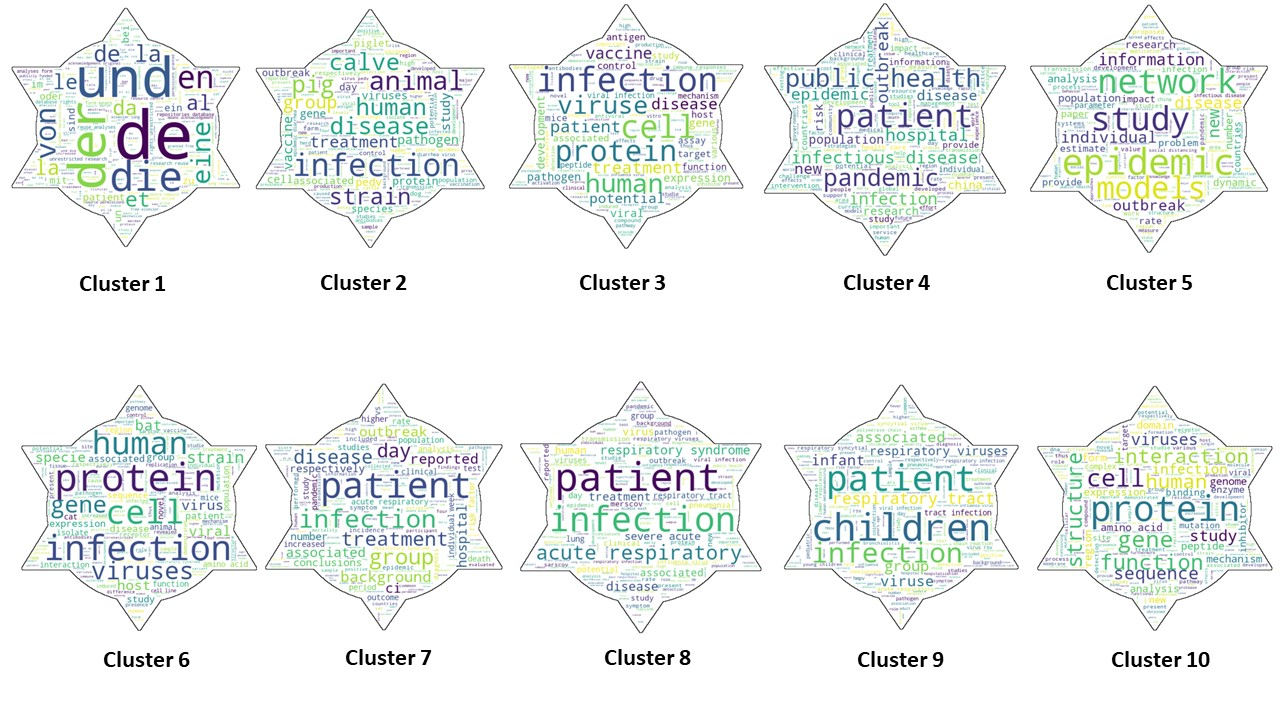

# 4. Conclusion

We presented straightforward unsupervised approach while using State-of-The-Art tools. 

We manually evaluated our results for a small set of questions, and got some interesting insights. 

Both method and evaluation represent solutions ideas. For fully developed solutions additional work needs to be done.


**Points for improvement**:
1.	The state-of-the-art tools used 'as is', a better approach is train these models on the corpos for knowledge domain shift.
2.	Add a “correctness” threshold: do not return answers below that threshold.
3.	Error analysis: check precision errors,  i.e., when the engine provided high confidence errors for wrong answers; and recall errors: when potentially good answers get low scores. 
4.	Evaluation: should be done on a large set of questions with a large team of annotators, and with Subject Matter Experts (people with biological background).


We hope that the notebook gave you more insights.
